# pearson score of local dataset

In [1]:
import scanpy as sc

adata = sc.read_h5ad('/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/data/finetune/grn/Immune_ALL_human.h5ad')
adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [2]:
adata.X.max()

12.041345

In [3]:
from biollm.repo.scgpt.preprocess import Preprocessor
ori_batch_col = "batch"
adata.obs["celltype"] = adata.obs["final_annotation"].astype(str)
data_is_raw = False
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=False,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=1200,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=False,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="batch")

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Subsetting highly variable genes ...


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

In [4]:
adata

AnnData object with n_obs × n_vars = 33506 × 1200
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'celltype'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts'

In [45]:
genes = list(adata.var.index)
[i for i in genes if 'CD3' in i]

['CD302', 'CD38', 'CD36', 'CD3E', 'CD3D', 'CD3G', 'CD300E']

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import tqdm
from collections import defaultdict

def cal_cos_similarity(embedding_dict, threshold=99):
    a = pd.DataFrame.from_dict(embedding_dict)
    similarities = cosine_similarity(a.T)
    genes = list(a.columns)
    cutoff_value = threshold
    cutoff_value = np.percentile(similarities, threshold)
    print(cutoff_value)
    cutoff_value = 0 if cutoff_value < 0 else cutoff_value
    similarities[similarities < cutoff_value] = 0
    nodes_weight = defaultdict(list)
    nz = list(zip(*similarities.nonzero()))
    print('len gene paries: ', len(nz))
    
    for n in tqdm.tqdm(nz):
        if n[0] != n[1]:
            nodes_weight['g1'].append(genes[n[0]])
            nodes_weight['g2'].append(genes[n[1]])
            nodes_weight['score'].append(similarities[n[0], n[1]])
            # nodes_weight.append((genes[n[0]], genes[n[1]], similarities[n[0], n[1]]))
    df = pd.DataFrame(nodes_weight)
    return df

def cal_bio_jacard(scores_df, gene_pw_dict):
    res = []
    for i in scores_df.index:
        set1 = set(gene_pw_dict[scores_df.iloc[i]['g1']])
        set2 = set(gene_pw_dict[scores_df.iloc[i]['g2']])
    
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
    
        jaccard_index = intersection / union
        res.append(jaccard_index)
    scores_df['jacard_dis'] = res

    return scores_df



In [6]:
import pickle 
import pickle

genes = list(adata.var.index)

pkl_file = "/home/share/huadjyin/home/s_huluni/project/bio_model/biollm/biollm/evaluate/gene_setinfo.pkl"
# Load the pickle file
with open(pkl_file, "rb") as file:
    gene_pw_dict = pickle.load(file)
corr_score = {}
genes = list(set(genes).intersection(set(gene_pw_dict.keys())))
print(len(genes))
for i in ['scbert', 'scgpt', 'scfoundation', 'geneformer']:
    with open(f'../../case/result/zero-shot/{i}_gene_emb.pk', 'rb') as f:
        emb = pickle.load(f)
    if not isinstance(emb['gene_emb'], np.ndarray):
        emb['gene_emb'] = emb['gene_emb'].cpu().detach().numpy()
    # np.random.shuffle(genes)
    # sub_genes = genes[0:1000]
    model_emb = {i: emb['gene_emb'][emb['gene_names'].index(i)] for i in genes if i in emb['gene_names']}
    print(f'get {len(model_emb)}/{len(genes)} genes')
    scores = cal_cos_similarity(model_emb)
    scores_df = cal_bio_jacard(scores, gene_pw_dict)
    corr = np.corrcoef(scores_df['score'].values, scores['jacard_dis'].values)
    corr_score[i] = corr[0, 1]

1138
get 1121/1138 genes
0.45687477402607024
len gene paries:  12567


100%|██████████| 12567/12567 [00:00<00:00, 811969.60it/s]
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


get 1138/1138 genes
0.26622363924980164
len gene paries:  12952


100%|██████████| 12952/12952 [00:00<00:00, 814425.52it/s]
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


get 1133/1138 genes
0.0852388775348661
len gene paries:  12837


100%|██████████| 12837/12837 [00:00<00:00, 794321.38it/s]
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


get 1131/1138 genes
0.5543607473373413
len gene paries:  12793


100%|██████████| 12793/12793 [00:00<00:00, 826533.54it/s]
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [140]:
corr_score

{'scbert': 0.13881069720483408,
 'scgpt': 0.33598432810723,
 'scfoundation': 3.0390867810700032e-05,
 'geneformer': 0.0298339051030289}

In [7]:
corr_score

{'scbert': 0.1353907582015316,
 'scgpt': 0.31853193996799295,
 'scfoundation': -0.0015463766221728442,
 'geneformer': 0.03406985192187215}

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/matplotlib/text.py:1465: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(self.convert_xunits(x))
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/matplotlib/text.py:756: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posx = float(self.convert_xunits(self._x))
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/matplotlib/text.py:897: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a 

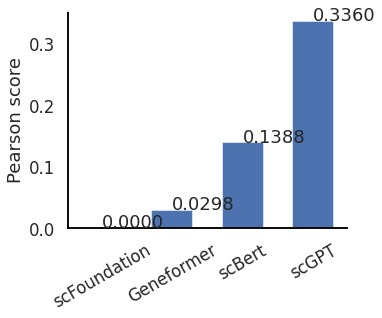

In [154]:
from matplotlib import pyplot as plt

x = ['scfoundation', 'geneformer', 'scbert', 'scgpt']
y = [corr_score[i] for i in x]
x = ['scFoundation', 'Geneformer', 'scBert', 'scGPT']
plt.figure(figsize=(5, 4))
axes_1 = plt.gca()
color_name = "black"
# axes_1.spines["top"].set_color(color_name)
axes_1.spines["bottom"].set_color(color_name)
axes_1.spines["left"].set_color(color_name)
# axes_1.spines["right"].set_color(color_name)
axes_1.patch.set_facecolor("white")
axes_1.axes.xaxis.set_visible(True)
plt.bar(x, y, width=0.6)
for i in range(len(x)):
    plt.annotate('%.4f' % y[i], xy = (x[i], y[i]), xytext=(x[i], y[i] + 0.001))
plt.xticks(rotation=30)
plt.ylabel('Pearson score')
plt.savefig('./fig4_gene_emb_corr_1.pdf', bbox_inches='tight')

# network of grn

In [8]:
import pickle 
from biollm.model.grn import GeneEmbedding
from collections import defaultdict
import numpy as np


model_mgs = {}
for i in ['scbert', 'scgpt', 'scfoundation', 'geneformer']:
    print(i)
    with open(f'../../case/result/zero-shot/{i}_gene_emb.pk', 'rb') as f:
        emb = pickle.load(f)
    genes = list(adata.var.index)
    if not isinstance(emb['gene_emb'], np.ndarray):
        emb['gene_emb'] = emb['gene_emb'].cpu().detach().numpy()
    # np.random.shuffle(genes)
    # sub_genes = genes[0:1000]
    model_emb = {i: emb['gene_emb'][emb['gene_names'].index(i)] for i in genes if i in emb['gene_names']}
    print(f'get {len(model_emb)}/{len(genes)} genes')
    embed = GeneEmbedding(model_emb)
    gdata = embed.get_adata() 
    # gdata = embed.get_adata(resolution=25)
    # Retrieve the gene clusters
    metagenes = embed.get_metagenes(gdata)
    mgs = dict()
    for mg, genes in metagenes.items():
        if len(genes) > 4:
            mgs[mg] = genes
            print(mg, genes)
    model_mgs[i] = mgs
    # CD_genes = defaultdict(list)
    # for m in mgs:
    #     for j in mgs[m]:
    #         if 'CD' in j:
    #             CD_genes[j].extend(mgs[m])
    # model_dc_genes[i] = CD_genes

scbert
get 1152/1200 genes


100%|██████████| 1152/1152 [00:00<00:00, 1328157.84it/s]


104 ['HES4', 'CAPG', 'GRINA', 'GRN', 'BLVRB']
43 ['ISG15', 'IFI6', 'HERC5', 'IFITM3', 'IRF7', 'IFIT2', 'IFIT3', 'IFIT1']
127 ['TNFRSF18', 'GMPR', 'PRKAR1B', 'MYEOV', 'TESC']
69 ['TNFRSF4', 'ZNF683', 'PTCH2', 'UBAP1L', 'SLC6A4', 'TTC38']
107 ['TNFRSF9', 'RALGPS2', 'RASGRP3', 'TMEM156', 'TNF']
101 ['RBP7', 'NINJ2', 'PLBD1', 'RAB31', 'PLAUR']
126 ['PGD', 'NFKBIA', 'SCPEP1', 'PARVB', 'PRR5']
53 ['TNFRSF1B', 'TMEM154', 'VNN2', 'NCF1', 'PILRA', 'SPI1', 'TYROBP']
111 ['EFHD2', 'DUSP2', 'FERMT3', 'IER2', 'ARRDC2']
76 ['DDI2', 'CD302', 'DOK7', 'DAB2', 'CES1', 'CCL3']
113 ['PADI2', 'PINK1', 'PLEK2', 'TEPP', 'MTMR3']
46 ['PADI4', 'LGALS12', 'NFE2', 'PHOSPHO1', 'PRAM1', 'VSTM1', 'FCAR']
2 ['CDA', 'ASPRV1', 'BASP1', 'ANKRD55', 'GADD45G', 'HAL', 'HCAR3', 'AQP9', 'MMP9', 'CYP4F3', 'APOBEC3A']
51 ['ID3', 'GRHL1', 'KLHDC8B', 'IGFBP3', 'GNG11', 'KRT5', 'ID1']
72 ['PITHD1', 'EIF2AK1', 'GAPVD1', 'MLH3', 'NARF', 'FAM210B']
80 ['RHD', 'TCEANC', 'MYBL1', 'SESN3', 'RPS6KA5', 'HERC1']
102 ['RHCE', 'NR4A1', 'PI

100%|██████████| 1174/1174 [00:00<00:00, 1222774.50it/s]


112 ['HES4', 'CLCN3', 'ENDOD1', 'ANKRD9', 'SCN1B']
3 ['ISG15', 'IFI6', 'IFI44L', 'CMPK2', 'RSAD2', 'STAT1', 'HERC5', 'SAMD9', 'IRF7', 'IFIT2', 'IFIT3', 'IFIT1', 'IRF9', 'IFI27', 'MX1']
88 ['TNFRSF18', 'TNFRSF4', 'TNFRSF9', 'RUNX3', 'IL2RA', 'DPYSL4']
33 ['TNFRSF25', 'CD247', 'PTPN7', 'ZAP70', 'TXK', 'ITK', 'CD5', 'CD7', 'TMIGD2']
131 ['RBP7', 'ABCG2', 'DAB2', 'NUP214', 'SLC6A4']
74 ['PGD', 'GCA', 'TKT', 'PLBD1', 'LTA4H', 'ALDH2', 'CES1']
50 ['TNFRSF1B', 'TGFBI', 'FGL2', 'AP1S2', 'MPEG1', 'TNFSF13B', 'POU2F2', 'TYMP']
115 ['EFHD2', 'CFH', 'OGFRL1', 'STEAP4', 'CEBPD']
90 ['DDI2', 'SLC37A3', 'GFOD2', 'RANBP10', 'FLCN', 'AKAP8L']
129 ['PADI2', 'CSF3R', 'CLEC12A', 'PRAM1', 'MYO1F']
52 ['PADI4', 'CDA', 'BST1', 'NINJ2', 'CLEC4D', 'VSTM1', 'FCAR', 'TNNT1']
101 ['PINK1', 'SHISA4', 'FKBP1B', 'BEX5', 'YPEL3', 'CDC34']
20 ['C1QA', 'C1QC', 'C1QB', 'FCGR3A', 'VSIG4', 'MS4A7', 'CD68', 'ACP5', 'APOE', 'APOC1']
102 ['ID3', 'ID2', 'HES1', 'DDIT4', 'RASD1', 'ID1']
108 ['MDS2', 'CPA5', 'CELA1', 'DACT1', '

100%|██████████| 1165/1165 [00:00<00:00, 1206509.67it/s]


31 ['ISG15', 'VCAN', 'MPEG1', 'IL2RA', 'CLEC7A', 'GSPT1']
82 ['RBP7', 'PDE4B', 'TPM2', 'PLD4', 'HERPUD1']
11 ['PGD', 'F11R', 'MTX3', 'CLEC12A', 'CD40', 'KCNG1', 'CLDN5']
10 ['TNFRSF1B', 'EGF', 'CA2', 'FGFR1OP2', 'HCK', 'FCGRT', 'IGLL5']
14 ['EFHD2', 'ZAP70', 'HLA-DMB', 'XPO7', 'DDIT4', 'CLK3', 'NARF']
74 ['PADI2', 'SH3YL1', 'ATP6V1C2', 'EGR3', 'PRDX2']
19 ['PADI4', 'PF4', 'PEG10', 'DPM2', 'MICAL2', 'SLC6A4', 'SMOX']
57 ['CDA', 'RNF11', 'ZNF789', 'GFI1B', 'IRAK3', 'CTSG']
61 ['PINK1', 'LY9', 'RALGPS2', 'MEIS1', 'APOBEC3A']
79 ['C1QA', 'JUN', 'STRADB', 'MEF2C', 'IRF7']
8 ['C1QC', 'SLC25A38', 'PIM2', 'CXCR3', 'PNOC', 'MS4A3', 'CLEC9A']
0 ['C1QB', 'PTCH2', 'FCER1G', 'GPR155', 'GPR55', 'SNCA', 'TTC16', 'ADM', 'TSC22D1']
59 ['ID3', 'FCGR2B', 'CPA3', 'CXCL10', 'CPEB4']
97 ['RUNX3', 'PLEK', 'LEF1', 'CTSA', 'KLF1']
34 ['RHD', 'ITM2C', 'PDE5A', 'MYC', 'SESN3', 'HNF1A']
13 ['RHCE', 'SLC11A1', 'ANKRD55', 'TRIM23', 'BRI3', 'LMO2', 'CABP5']
23 ['ZNF683', 'ATF3', 'ASF1A', 'FLCN', 'CYGB', 'LGALS2']
58

100%|██████████| 1160/1160 [00:00<00:00, 1186391.77it/s]


13 ['HES4', 'EREG', 'EFHC1', 'ASF1A', 'JAM3', 'SLC7A7', 'PYGL', 'NEIL1', 'SMPD3', 'USP10', 'SOCS3']
35 ['ISG15', 'ID3', 'ZEB2', 'IL7R', 'KLRG1', 'BCL2A1', 'RUNDC3A', 'ID1', 'JSRP1']
70 ['TNFRSF18', 'FCRL3', 'BANK1', 'SH2D1A', 'IL2RA', 'GPR18', 'GZMM']
132 ['TNFRSF4', 'OSBPL10', 'ARHGAP24', 'NEK8', 'IGLL5']
92 ['TNFRSF25', 'CTSS', 'TTC16', 'FAM102A', 'CARNS1', 'GP1BA', 'TMIGD2']
114 ['TNFRSF9', 'FCGR2B', 'ZNF789', 'CA3', 'GZMB', 'PTPRS']
131 ['RBP7', 'CA8', 'TSPAN9', 'CLEC1B', 'AATK']
0 ['PGD', 'DDI2', 'MDS2', 'SLC16A1', 'QPCT', 'IER3', 'FBXO9', 'MKRN1', 'AP1S2', 'SAT1', 'STOM', 'ADAM12', 'FGFR1OP2', 'SLC25A39']
32 ['TNFRSF1B', 'PTGS2', 'ADIPOR1', 'TTN', 'IL3RA', 'ZFAND5', 'TLE1', 'MINPP1', 'SNX22', 'FCGRT']
33 ['EFHD2', 'CDA', 'STAT1', 'MYCT1', 'PIM2', 'ST3GAL1', 'CD5', 'OPTN', 'CTSZ', 'PRRG2']
95 ['PADI2', 'EBF1', 'S1PR3', 'HRK', 'KLHDC2', 'FECH']
43 ['PADI4', 'CISH', 'IGFBP7', 'CLIC2', 'TEX12', 'CALCOCO1', 'NPRL3', 'MYL9', 'BLVRB']
62 ['PINK1', 'IFI6', 'MPP1', 'CDC14B', 'CKB', 'LTK',

In [121]:
# CD3E


scbert
['GIMAP7', 'GIMAP4', 'GIMAP6', 'GIMAP1', 'ITM2A', 'CD3E', 'HERPUD1']
(42, 3)
scgpt
['LCK', 'CD8A', 'CD8B', 'MAL', 'TCF7', 'PTCRA', 'CD3E', 'CD3D', 'CD3G', 'LAT', 'GRAP2']
(110, 3)
scfoundation
['TNFRSF25', 'NFKBIZ', 'OPA1', 'TSPAN5', 'CD3E', 'RTKN2']
(30, 3)
geneformer
['TNFRSF25', 'SCN3A', 'FAM102A', 'CAT', 'CD3E', 'DLEU7', 'GTF3C1', 'GP1BA', 'SIRPG', 'TMIGD2']


/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/biollm/model/grn.py:178: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distance = float(
/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/biollm/model/grn.py:178: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distance = float(
/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/biollm/model/grn.py:178: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1

(90, 3)


/tmp/ipykernel_3696084/2256041603.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_CD = df_CD.append(df)
/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/biollm/model/grn.py:178: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distance = float(
/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/biollm/model/grn.py:178: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distance = float(
/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/biollm/model/grn.py:178: DeprecationWar

scbert
['ISG15', 'IFI6', 'HERC5', 'IFITM3', 'IRF7', 'IFIT2', 'IFIT3', 'IFIT1']
(56, 3)
scgpt
['ISG15', 'IFI6', 'IFI44L', 'CMPK2', 'RSAD2', 'STAT1', 'HERC5', 'SAMD9', 'IRF7', 'IFIT2', 'IFIT3', 'IFIT1', 'IRF9', 'IFI27', 'MX1']


/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/biollm/model/grn.py:178: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distance = float(
/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/biollm/model/grn.py:178: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distance = float(
/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/biollm/model/grn.py:178: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1

(210, 3)
geneformer
['CDKN2C', 'FCGR3A', 'CMC1', 'ACTA2', 'IFIT3', 'IFIT1', 'CMAS']
(42, 3)
scbert


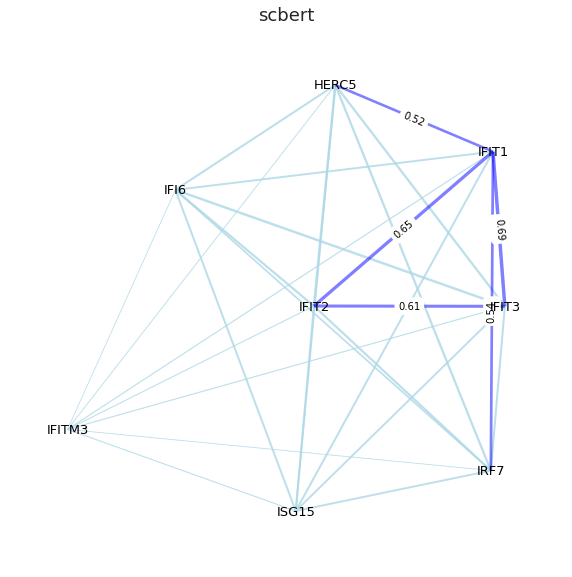

scgpt


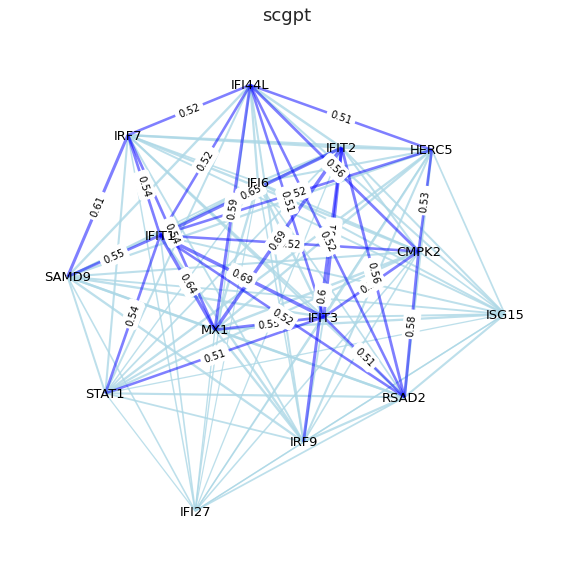

geneformer


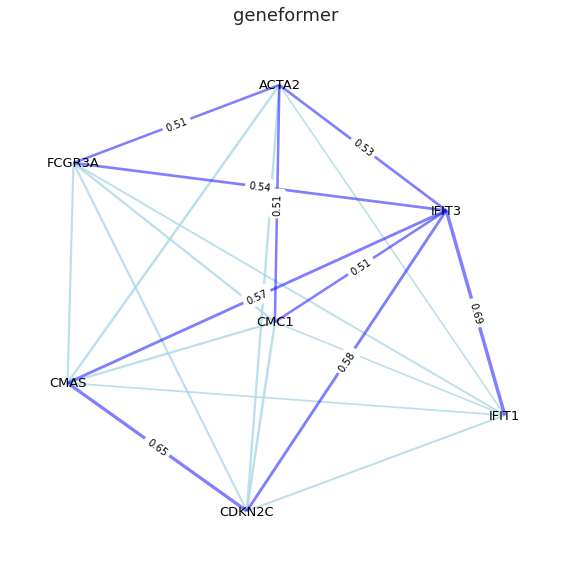

In [14]:
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx


target_gene = 'IFIT1'
# target_gene = 'HLA-DRA'
thresh = 0.5
model_target_mgs = defaultdict(list)
for model in model_mgs:
    mgs = model_mgs[model]
    for m in mgs:
        for j in mgs[m]:
            if target_gene in j:
                model_target_mgs[model] = mgs[m]
plot_graph = {}
for model in model_target_mgs:
    print(model)
    plot_genes = model_target_mgs[model]
    print(plot_genes)
    df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
    for j in plot_genes:
        df = embed.compute_similarities(j, plot_genes)
        df['Gene1'] = j
        df_CD = df_CD.append(df)
    df_CD_sub = df_CD[df_CD['Similarity']<0.99].sort_values(by='Gene')
    print(df_CD_sub.shape)
    input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
    G = nx.Graph()
    G.add_weighted_edges_from(input_node_weights)
    plot_graph[model] = G



# _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 10))
n = 0
# axes = [ax1, ax2, ax3, ax4]
for model in plot_graph:
    print(model)
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    G = plot_graph[model]
    # ax = axes[n]
    # n += 1
    widths = nx.get_edge_attributes(G, 'weight')
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]
    pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)
    width_large = {}
    width_small = {}
    for i, v in enumerate(list(widths.values())):
        if v > thresh:
            width_large[list(widths.keys())[i]] = v*5
        else:
            width_small[list(widths.keys())[i]] = max(v, 0)*5
    
    nx.draw_networkx_edges(G, pos,
                           edgelist = width_small.keys(),
                           width=list(width_small.values()),
                           edge_color='lightblue',
                           alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G, pos, 
                           edgelist = width_large.keys(), 
                           width = list(width_large.values()), 
                           alpha = 0.5, 
                           edge_color = "blue", 
                           ax=ax
                          )
    # node labels
    nx.draw_networkx_labels(G, pos, font_size=13, font_family="sans-serif", ax=ax)
    # edge weight labels
    d = nx.get_edge_attributes(G, "weight")
    edge_labels = {k: d[k] for k in elarge}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10, ax=ax)
    ax.margins(0.08)
    ax.set_title(model)
    ax.patch.set_facecolor("white")
    # plt.savefig(f'./fig4_gene_emb_network_{model}_{target_gene}.pdf', bbox_inches='tight')
    plt.show()
    
# ax = plt.gca()
# ax.margins(0.08)
# plt.axis("off")
# plt.show()

In [11]:
genes = list(adata.var.index)
for i in genes:
    if 'CD' in i:
        print(i)

CDA
CDC20
CDKN2C
CD2
CD160
CD1D
CD1C
CD247
CD8A
CD8B
CD302
PDCD1
CD96
CD200
PDCD10
CCDC50
CD38
CD180
CD14
CD74
CD83
CDKN1A
CD36
CD40LG
CD72
CDC14B
CDKN1C
CD59
CD5
CDNF
CDK1
DPCD
CD9
CD27
CD69
PCDH9
CD19
CD68
CCDC144NL
CDK12
CDC27
CD79B
CD300E
CD7
CD93
CD40
CDC34
CD70
CDKN2D
CD22
CD79A


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:17

<Figure size 360x936 with 0 Axes>

<Figure size 432x288 with 0 Axes>

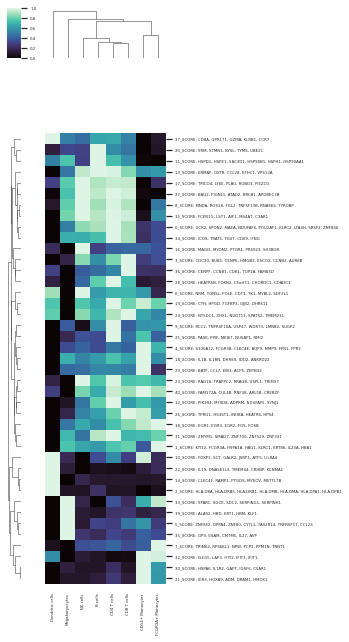

In [11]:
import seaborn as sns

sns.set(font_scale=0.35)
embed.score_metagenes(adata, metagenes)
embed.plot_metagenes_scores(adata, mgs, "celltype")